# Capstone Project - The Battle of the Neighborhoods
## Applied Data Science Capstone by IBM/Coursera


## Table of contents

* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

Although the pandemic has made it difficult for many businesses to survive, the economy is still growing in the United States and many companies are looking for opportunities to expand their business.

Our company wants to start a bakery restaurant chain in two cities in the USA.
For particular reasons, there are two cities which have been selected for starting new businesses : Washington D.C. and Portland, Oregon.

The two cities are comparable in size (not counting their metro area), but there are many differences. Washington D.C. is the capital of the United States and is a principal city of the East Cost, while Portland, although a large city, is not a capital and is located on the West Cost.

This report will feature a brief comparison of the two cities, and will attempt to analyze data in order to present an ensemble of possible locations for our businesses. We will start by using data to retrieve existing food and bakery businesses, analyze our data, and finally determine which neighborhoods could be a good spot for a bakery.

Stakeholders will be able to examine the data and base their decisions on the conclusions presented in this report.

## Data <a name="data"></a>

There are several factors that can influence a stakeholder's decision. The factors chosen here are the following:
* the existing bakeries and their density in an area
* the distance from the city center

Each city will be divided into a grid of "blocks" (each equal in size) algorithmically, which we will use to retrieve our data and define our neighborhoods.

For this study we will be using these data sources :
* **Google Maps** for the coordinates of each cities
* the **Folium library** for the city maps
* the **Foursquare API** for all the venue locations along with their categories in a block

Obtaining all the information about bakeries in one call to the Foursquare API is not possible due to limits placed on the number of results and the covered area. To circumvent this obstacle we will be calling the API block by block.

Another data source that we will need is the list of categories provided by Foursquare. This data is available through the API, but the hierarchical structure of the data make it necessary to search the categories recursively, which is not practical (of efficient). So the solution here is to simply create a csv file by hand from the Foursquare website (https://developer.foursquare.com/docs/build-with-foursquare/categories/) that we can load into a regular DataFrame.

Importing necessary libraries

In [1]:
#!pip install shapely
import shapely.geometry

#!pip install pyproj
import pyproj

import math

import requests # library to handle requests

from pandas import json_normalize # tranform JSON file into a pandas dataframe
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 

#!pip install folium

import folium

### Washington D.C. Data

Generating block centers

In [2]:
def lonlat_to_xy(lon, lat, zone):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=zone, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y, zone):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=zone, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

def generate_neigh_centers(center, zone):
    center_x, center_y = lonlat_to_xy(center[1], center[0], zone) # City center in Cartesian coordinates

    k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
    x_min = center_x - 6000
    x_step = 600
    y_min = center_y - 6000 - (int(21/k)*k*600 - 12000)/2
    y_step = 600 * k 

    latitudes = []
    longitudes = []
    distances_from_center = []
    xs = []
    ys = []
    for i in range(0, int(21/k)):
        y = y_min + i * y_step
        x_offset = 300 if i%2==0 else 0
        for j in range(0, 21):
            x = x_min + j * x_step + x_offset
            distance_from_center = calc_xy_distance(center_x, center_y, x, y)
            if (distance_from_center <= 6001):
                lon, lat = xy_to_lonlat(x, y, zone)
                latitudes.append(lat)
                longitudes.append(lon)
                distances_from_center.append(distance_from_center)
                xs.append(x)
                ys.append(y)
    return (latitudes, longitudes, distances_from_center)



In [3]:
wa_center = [38.90693491390886, -77.03517715787622]

# Important : we have to be sure to use the right utm zone for each city
latitudes, longitudes, distances_from_center = generate_neigh_centers(wa_center, 18)
print(len(latitudes), 'candidate neighborhood centers generated.')

<ipython-input-2-95fc8fd2e047>:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This funct

364 candidate neighborhood centers generated.


<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This func

Displaying the blocks on the map

In [4]:
map_wa = folium.Map(location=wa_center, zoom_start=12)
folium.Marker(wa_center, popup='Center').add_to(map_wa)
for lat, lon in zip(latitudes, longitudes):
    folium.Circle([lat, lon], radius=300, color='blue', fill=False).add_to(map_wa)
map_wa

In [5]:
map_wa.save('map_wa_blocks.html')

Retrieving Data from Foursquare

In [6]:
CLIENT_ID = '05AJWSKQWFTDTHSZXVN5SCLWAQ2UKLPMHDGBLXXKFPIIWXZL' # your Foursquare ID
CLIENT_SECRET = 'XL1IYCCRRLYJ0SHSKVG3M0IUP12T5MLCKXM0YXPBQH2VKL0U' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 10 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def getFourSquareVenues(results):
    if len(results['response']) > 0 and len(results['response']['groups']) > 0:
        venues = results['response']['groups'][0]['items']

        nearby_venues = json_normalize(venues) # flatten JSON
        print('columns : ', len(nearby_venues.columns))

        # filter columns
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']

        if (len(nearby_venues.columns) > 0):
            nearby_venues =nearby_venues.loc[:, filtered_columns]

            # filter the category for each row
            nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

            # clean columns
            nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
            print(nearby_venues.shape)

            return nearby_venues
        else:
            # Return empty DataFrame
            print('Empty !')
            return pd.DataFrame(columns=['name', 'categories', 'lat', 'lng'])
        
def get_venues(latitudes, longitudes):
    LIMIT = 100
    radius = 300

    venues = pd.DataFrame(columns=['block_lat', 'block_lon', 'name', 'categories', 'lat', 'lng'])

    for lat, lon in zip(latitudes, longitudes):
        print(lat, lon)

        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lon, VERSION, radius, LIMIT)
        results = requests.get(url).json()

        nearby_venues = getFourSquareVenues(results)

        #print(nearby_venues[['name', 'categories']])
        if nearby_venues is not None and len(nearby_venues):
            nearby_venues['block_lat'] = lat
            nearby_venues['block_lon'] = lon
            venues = venues.append(nearby_venues)

    return venues



Your credentails:
CLIENT_ID: 05AJWSKQWFTDTHSZXVN5SCLWAQ2UKLPMHDGBLXXKFPIIWXZL
CLIENT_SECRET:XL1IYCCRRLYJ0SHSKVG3M0IUP12T5MLCKXM0YXPBQH2VKL0U


In [7]:
#wa_venues = get_venues(latitudes, longitudes)

In [8]:
#wa_venues.to_pickle('./locations_wa.pkl')

In [9]:
wa_venues = pd.read_pickle('./locations_wa.pkl')
print(wa_venues.shape)
print(wa_venues[wa_venues['categories']=='Bakery'].shape)

(3778, 6)
(37, 6)


Displaying bakeries on the map

In [10]:
wa_center = [38.90720207588509, -77.03586380335906]

wa_bakeries = wa_venues[wa_venues['categories']=='Bakery']

latitudes = wa_bakeries['lat']
longitudes = wa_bakeries['lng']

map_wa = folium.Map(location=wa_center, zoom_start=12)
folium.Circle(wa_center, radius=6000, color='blue', fill=False).add_to(map_wa)
for lat, lon in zip(latitudes, longitudes):
    bakery = wa_bakeries[(wa_bakeries['lat'] == lat) & (wa_bakeries['lng'] == lon)]
    name = bakery['name'].values[0].replace('\'', ' ')
    folium.Marker([lat, lon], popup=name).add_to(map_wa)
map_wa

### Portland Data

Generating block centers

In [11]:
po_center = [45.50401002495479, -122.67865936022955]

latitudes, longitudes, distances_from_center = generate_neigh_centers(po_center, 10)
print(len(latitudes), 'candidate neighborhood centers generated.')

<ipython-input-2-95fc8fd2e047>:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This funct

<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This func

<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This func

364 candidate neighborhood centers generated.


<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
<ipython-input-2-95fc8fd2e047>:10: DeprecationWarning: This func

In [12]:
map_po = folium.Map(location=po_center, zoom_start=12)
folium.Marker(po_center, popup='Center').add_to(map_po)
for lat, lon in zip(latitudes, longitudes):
    folium.Circle([lat, lon], radius=300, color='blue', fill=False).add_to(map_po)
map_po

Retrieving Portland venues

In [13]:
# Uncomment to call the Foursquare API
#po_venues = get_venues(latitudes, longitudes)
#get_venues([45.5412747647136], [-122.62849176607801])

In [14]:
#po_venues.to_pickle('locations_po.pkl')


In [15]:
po_venues = pd.read_pickle('locations_po.pkl')
print(po_venues.shape)
print(po_venues[po_venues['categories']=='Bakery'].shape)

(2539, 6)
(27, 6)


Displaying the bakeries in Portland

In [16]:
po_center = [45.50401002495479, -122.67865936022955]
po_bakeries = po_venues[po_venues['categories']=='Bakery']

latitudes = po_bakeries['lat']
longitudes = po_bakeries['lng']

map_po = folium.Map(location=po_center, zoom_start=12)
folium.Circle(po_center, radius=6000, color='blue', fill=False).add_to(map_po)
for lat, lon in zip(latitudes, longitudes):
    bakery = po_bakeries[(po_bakeries['lat'] == lat) & (po_bakeries['lng'] == lon)]
    name = bakery['name'].values[0].replace('\'', ' ')
    folium.Marker([lat, lon], popup=name).add_to(map_po)
map_po

### Methodology <a name="methodology"></a>

In this project we will try to detect areas that have low bakeries density, for the two cities. We will limit our analysis to an area of ~6km around the city center.

In first step we have collected the the location and type of every venue, along with the bakeries of the two cities.

Secondly the data will be analyzed to provide us with the most represented food businesses and the respective rank of bakeries in the cities.

In a third step we will explore the food business density across different areas of the Washington and Portland, and to do this we will use heatmaps to identify a the areas with low number of bakeries.

In the final step we will create clusters of locations of bakeries. This will help us identify neighborhoods which should be a starting point for a more detailed exploration by stakeholders.


### Analysis <a name="analysis"></a>

#### Washington D.C. Analysis

What kind of food businesses are mostly represented ?

In [17]:
all_categories = pd.read_csv('all_categories.csv')
food_categories = all_categories[all_categories['top_category']=='Food']['subcategory']
print(f'There are {food_categories.shape[0]} food categories in our data.')

There are 165 food categories in our data.


In [18]:
wa_food_venues = wa_venues[wa_venues['categories'].isin(food_categories.values)]
print(f'There are {wa_venues.shape[0]} venues in our data, including {wa_food_venues.shape[0]} food venues.')

There are 3778 venues in our data, including 1572 food venues.


In [19]:
wa_food_venues.sort_values
wa_food_numbers = wa_food_venues.groupby(['categories']).count()['name'].sort_values(ascending=False)
wa_food_numbers.head(10)

wa_food_percent = round(wa_food_numbers/wa_food_numbers.sum() * 100, 2)
wa_food_percent


categories
Coffee Shop               8.14
Sandwich Place            6.23
Pizza Place               5.98
American Restaurant       4.90
Food Truck                4.90
                          ... 
Burmese Restaurant        0.06
Belgian Restaurant        0.06
Austrian Restaurant       0.06
Arepa Restaurant          0.06
Gluten-free Restaurant    0.06
Name: name, Length: 96, dtype: float64

In [20]:
# Group categories below 1 % into 'Other' category
wa_under_1_percent = wa_food_percent[wa_food_percent<1].sum()
wa_under_1_percent


22.229999999999993

In [21]:
wa_food_percent.drop(wa_food_percent[wa_food_percent<5].index)

wa_food_percent['other'] = wa_under_1_percent
wa_food_percent

categories
Coffee Shop                8.14
Sandwich Place             6.23
Pizza Place                5.98
American Restaurant        4.90
Food Truck                 4.90
                          ...  
Belgian Restaurant         0.06
Austrian Restaurant        0.06
Arepa Restaurant           0.06
Gluten-free Restaurant     0.06
other                     22.23
Name: name, Length: 97, dtype: float64

Let's take a look at a food categories pie chart.

<AxesSubplot:title={'center':'Food venues in Washington DC'}, ylabel='name'>

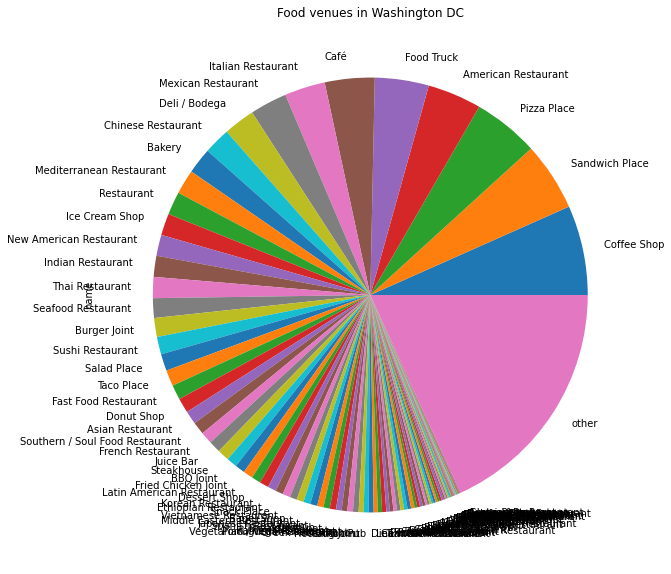

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

wa_food_percent.plot(kind='pie', title='Food venues in Washington DC')

According to Foursquare, bakeries are not in the top ten most represented food businesses in Washington (at 11th position).

Where are the food businesses ?

In [23]:
# A heatmap showing all the food businesses

from folium import plugins
from folium.plugins import HeatMap

wa_food_venues = wa_venues[wa_venues['categories'].isin(food_categories.values)]

restaurant_latlons = [[res[0], res[1]] for res in wa_venues[['lat', 'lng']].values]

map_wa = folium.Map(location=wa_center, zoom_start=12)
folium.TileLayer('cartodbpositron').add_to(map_wa) #cartodbpositron cartodbdark_matter
HeatMap(restaurant_latlons).add_to(map_wa)
folium.Marker(wa_center).add_to(map_wa)
folium.Circle(wa_center, radius=6000, color='blue', fill=False).add_to(map_wa)
folium.Circle(wa_center, radius=1000, fill=False, color='white').add_to(map_wa)
folium.Circle(wa_center, radius=2000, fill=False, color='white').add_to(map_wa)
folium.Circle(wa_center, radius=3000, fill=False, color='white').add_to(map_wa)
map_wa

As we can see here the food business presence is very dense in the whole area that we are examining.

Let's show a heatmap of bakeries only

In [24]:
from folium import plugins
from folium.plugins import HeatMap

wa_bakeries_latlons = [[res[0], res[1]] for res in wa_bakeries[['lat', 'lng']].values]

map_wa = folium.Map(location=wa_center, zoom_start=12)
folium.TileLayer('cartodbpositron').add_to(map_wa) #cartodbpositron cartodbdark_matter
HeatMap(wa_bakeries_latlons).add_to(map_wa)
folium.Marker(wa_center).add_to(map_wa)
folium.Circle(wa_center, radius=6000, color='blue', fill=False).add_to(map_wa)
folium.Circle(wa_center, radius=1000, fill=False, color='black').add_to(map_wa)
folium.Circle(wa_center, radius=2000, fill=False, color='black').add_to(map_wa)
folium.Circle(wa_center, radius=3000, fill=False, color='black').add_to(map_wa)
map_wa

Here we can see that the bakeries density is sparse compared to the rest of the food venues.

#### Clustering Washington Bakeries

Let's try to cluster the bakeries geographically

In [25]:
# venues
wa_bakeries_clustering = wa_bakeries[['lat', 'lng']]


In [26]:

def get_cluster(data, clusterNum = 5):
    # cluster the venues by lat / lon
    
    data_cluster = pd.DataFrame(data)
    
    k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
    k_means.fit(data_cluster)
    labels = k_means.labels_
    #print(labels)

    # Assign the clusters we have found to the items
    data_cluster['cluster'] = labels
    #print(data_cluster.head())
    return (k_means, data_cluster)

def add_cluster_to_map(wa_bakeries_clustering, n_cluster, map_wa, color):
    for index, data in wa_bakeries_clustering[wa_bakeries_clustering['cluster']==n_cluster].iterrows():
        folium.Circle([data['lat'], data['lng']], radius=300, color=color, fill=False).add_to(map_wa)


In [27]:
# 2 Clusters

k_means, data_cluster = get_cluster(wa_bakeries_clustering, 2)

map_wa = folium.Map(location=wa_center, zoom_start=12)

folium.Circle(wa_center, radius=6000, color='blue', fill=False).add_to(map_wa)
for index, data in wa_bakeries_clustering[wa_bakeries_clustering['cluster']==0].iterrows():
    folium.Circle([data['lat'], data['lng']], radius=300, color='blue', fill=False).add_to(map_wa)
for index, data in wa_bakeries_clustering[wa_bakeries_clustering['cluster']==1].iterrows():
    folium.Circle([data['lat'], data['lng']], radius=300, color='brown', fill=False).add_to(map_wa)
map_wa

With two clusters, the businesses are divided between a west cluster and an east-center cluster, or a center cluster and a peripheral cluster (depending on code execution, as the result is not deterministic).

In [28]:
# 3 Clusters

k_means, data_cluster = get_cluster(wa_bakeries_clustering, 3)

map_wa = folium.Map(location=wa_center, zoom_start=12)

folium.Circle(wa_center, radius=6000, color='blue', fill=False).add_to(map_wa)
add_cluster_to_map(wa_bakeries_clustering, 0, map_wa, 'blue')
add_cluster_to_map(wa_bakeries_clustering, 1, map_wa, 'brown')
add_cluster_to_map(wa_bakeries_clustering, 2, map_wa, 'red')
map_wa

With three clusters, the businesses are divided between a west cluster, a northe-center cluster and an south-east cluster.

In [29]:
# 4 Clusters

k_means, data_cluster = get_cluster(wa_bakeries_clustering, 4)

map_wa = folium.Map(location=wa_center, zoom_start=12)

folium.Circle(wa_center, radius=6000, color='blue', fill=False).add_to(map_wa)
add_cluster_to_map(wa_bakeries_clustering, 0, map_wa, 'blue')
add_cluster_to_map(wa_bakeries_clustering, 1, map_wa, 'brown')
add_cluster_to_map(wa_bakeries_clustering, 2, map_wa, 'red')
add_cluster_to_map(wa_bakeries_clustering, 3, map_wa, 'violet')
map_wa

With four clusters, a fourth cluster appears in the south west after dividing the west cluster in two.

In [30]:
# 5 Clusters

k_means, data_cluster = get_cluster(wa_bakeries_clustering, 5)

map_wa = folium.Map(location=wa_center, zoom_start=12)

folium.Circle(wa_center, radius=6000, color='blue', fill=False).add_to(map_wa)
add_cluster_to_map(wa_bakeries_clustering, 0, map_wa, 'blue')
add_cluster_to_map(wa_bakeries_clustering, 1, map_wa, 'brown')
add_cluster_to_map(wa_bakeries_clustering, 2, map_wa, 'red')
add_cluster_to_map(wa_bakeries_clustering, 3, map_wa, 'violet')
add_cluster_to_map(wa_bakeries_clustering, 4, map_wa, 'yellow')
map_wa

In [38]:
# 6 Clusters

k_means, data_cluster = get_cluster(wa_bakeries_clustering, 6)

map_wa = folium.Map(location=wa_center, zoom_start=12)

folium.Circle(wa_center, radius=6000, color='blue', fill=False).add_to(map_wa)
add_cluster_to_map(wa_bakeries_clustering, 0, map_wa, 'blue')
add_cluster_to_map(wa_bakeries_clustering, 1, map_wa, 'brown')
add_cluster_to_map(wa_bakeries_clustering, 2, map_wa, 'red')
add_cluster_to_map(wa_bakeries_clustering, 3, map_wa, 'violet')
add_cluster_to_map(wa_bakeries_clustering, 4, map_wa, 'yellow')
add_cluster_to_map(wa_bakeries_clustering, 5, map_wa, 'white')
map_wa

With six clusters a sixth one appears in the north-west by dividing the west center again.

The six clusters option seems to be more useful, as each cluster is more coherent and the spread is more harmonious.

#### Preliminary observations

There are several zone which can be of interest, as they are less dense (starting the from north west) :
- Cleveland Park / Glover Park
- Fort Meyer and south of the Arlington Cemetery
- Navy Yard Ballpark
- Langston
- Northeast


#### Portland Analysis

In [32]:
# A heatmap showing all the food businesses

from folium import plugins
from folium.plugins import HeatMap

po_food_venues = po_venues[po_venues['categories'].isin(food_categories.values)]

restaurant_latlons = [[res[0], res[1]] for res in po_venues[['lat', 'lng']].values]

map_po = folium.Map(location=po_center, zoom_start=12)
folium.TileLayer('cartodbpositron').add_to(map_po) #cartodbpositron cartodbdark_matter
HeatMap(restaurant_latlons).add_to(map_po)
folium.Marker(po_center).add_to(map_po)
folium.Circle(po_center, radius=6000, color='blue', fill=False).add_to(map_po)
folium.Circle(po_center, radius=1000, fill=False, color='white').add_to(map_po)
folium.Circle(po_center, radius=2000, fill=False, color='white').add_to(map_po)
folium.Circle(po_center, radius=3000, fill=False, color='white').add_to(map_po)
map_po

The food venues are dense except maybe on the rivers and in the western part of the city (Bridlemile).

In [33]:
from folium import plugins
from folium.plugins import HeatMap

po_bakeries_latlons = [[res[0], res[1]] for res in po_bakeries[['lat', 'lng']].values]

map_po = folium.Map(location=po_center, zoom_start=12)
folium.TileLayer('cartodbpositron').add_to(map_po) #cartodbpositron cartodbdark_matter
HeatMap(po_bakeries_latlons).add_to(map_po)
folium.Marker(po_center).add_to(map_po)
folium.Circle(po_center, radius=6000, color='blue', fill=False).add_to(map_po)
folium.Circle(po_center, radius=1000, fill=False, color='black').add_to(map_po)
folium.Circle(po_center, radius=2000, fill=False, color='black').add_to(map_po)
folium.Circle(po_center, radius=3000, fill=False, color='black').add_to(map_po)
map_po

Most of the bakeries seem to be concentrated in the north-east, which is very interesting.

Food businesses most present in Portland

In [34]:
po_food_venues = po_venues[po_venues['categories'].isin(food_categories.values)]
print(f'There are {po_venues.shape[0]} venues in our data, including {po_food_venues.shape[0]} food venues.')

There are 2539 venues in our data, including 1030 food venues.


<AxesSubplot:title={'center':'Food venues in Portland'}, ylabel='name'>

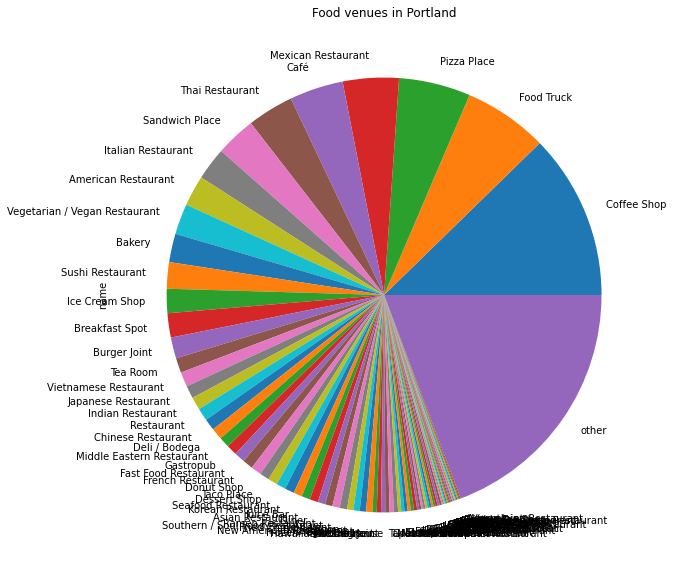

In [35]:
po_food_venues.sort_values
po_food_numbers = po_food_venues.groupby(['categories']).count()['name'].sort_values(ascending=False)
po_food_numbers.head(10)

po_food_percent = round(po_food_numbers/po_food_numbers.sum() * 100, 2)
po_food_percent

# Group categories below 1 % into 'Other' category
po_under_1_percent = po_food_percent[po_food_percent<1].sum()
po_under_1_percent

po_food_percent.drop(po_food_percent[po_food_percent<5].index)

po_food_percent['other'] = po_under_1_percent
po_food_percent

import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

po_food_percent.plot(kind='pie', title='Food venues in Portland')

Bakeries are also at 11th position in most represented food businesses in Portland.

#### Clustering Portland Bakeries

In [36]:
# venues
po_bakeries_clustering = po_bakeries[['lat', 'lng']]


There are few bakeries appearing on the map with the Foursquare API, and the area is very spread out. Fewer numbers of clusters than 5 show very spread out clusters and are therefore not really interesting.

Let's show 6 clusters on a map

In [37]:
# 6 Clusters

k_means, data_cluster = get_cluster(po_bakeries_clustering, 6)

map_po = folium.Map(location=po_center, zoom_start=12)

folium.Circle(po_center, radius=6000, color='blue', fill=False).add_to(map_po)
add_cluster_to_map(po_bakeries_clustering, 0, map_po, 'blue')
add_cluster_to_map(po_bakeries_clustering, 1, map_po, 'brown')
add_cluster_to_map(po_bakeries_clustering, 2, map_po, 'red')
add_cluster_to_map(po_bakeries_clustering, 3, map_po, 'violet')
add_cluster_to_map(po_bakeries_clustering, 4, map_po, 'yellow')
add_cluster_to_map(po_bakeries_clustering, 5, map_po, 'white')
map_po

#### Preliminary observations

The following areas seem to be interesting :
- Southwest hills, particularly Bridlemile and Healy Heights
- South waterfront
- South Burlingame
- Reed university

#### Analysis - A Comparison

According to the Foursquare API, Washington DC seems to be more populated in food venues with around 1570 food businesses against 1030 for Portland.

In Portland food venues are more densely located in the center, north and eastern part of the city. Whereas in Washington DC the food venues are more evenly distributed around the city center, but slightly concentrated in the center and southern part.

Interestingly, bakeries appear at the 11th position in both cities.

## Results and Discussion <a name="results"></a>

#### Washington DC
After clustering the groceries we can see that the south, north east and north west parts of Washington seem to be less dense than the others.
The center, western and eastern quadrants are more dense apparently.

These neighborhoods seem particularly interesting :
- Cleveland Park / Glover Park
- Fort Meyer and south of the Arlington Cemetery
- Navy Yard Ballpark
- Langston
- Northeast and University




*********************
*********************


#### Portland
The western, south-western and south-eastern clusters seem to be less dense than the others.
The north-eastern quadrant is especially dense apparently.
There are also many holes between the clusters.

These neighborhoods seem particularly interesting :
- Southwest hills, particularly Bridlemile and Healy Heights
- South waterfront
- South Burlingame
- Reed university

Note : Aside from the results that Foursquare returns, one should search for bakeries with
another search tools to prevent missing data like Google Maps or Bing for example.


# Conclusion <a name="conclusion"></a>

In this study, we analysed the data provided by Foursquare concerning food venues in Washington DC and Portland, especially bakeries.

We saw that bakeries are present in these cities, although are far less common than other food businesses like Coffee Shops and Pizza Place. So the competition is active but there are probably opportunities in these cities.

With the use of heatmaps we noticed that certain areas were especially less dense in bakeries than the rest of the city.

We clustered bakeries so that we could further identify the areas which seemed empty of our target business. For Washington DC, there are five neighborhoods that are interesting because they seem to be almost empty of bakeries although they are inhabited. Concerning Portland there are four such areas.

These conclusions could be useful for stakeholders to help them target their efforts in testing the interesting neighborhoods or conducting surveys before starting the businesses properly speaking (as well as a costly marketing campaign).